### 데이터 확인

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/netflix_customer_churn.csv')

In [6]:
display(df.head())
print(f'df.shape : {df.shape}, df.size : {df.size}')

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


df.shape : (5000, 14), df.size : 70000


In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

None

In [8]:
df.gender.unique()

array(['Other', 'Female', 'Male'], dtype=object)

In [9]:
df.isna().sum()
df.nunique()

customer_id               5000
age                         53
gender                       3
subscription_type            3
watch_hours               2343
last_login_days             61
region                       6
device                       5
monthly_fee                  3
churned                      2
payment_method               5
number_of_profiles           5
avg_watch_time_per_day     505
favorite_genre               7
dtype: int64

In [10]:
# 'Other' 성별을 기존 Female/Male 비율에 따라 비율적으로 분배합니다
# (재현을 위해 시드 고정). 만약 Female+Male이 없으면 50:50으로 분배합니다
import numpy as np
other_mask = df['gender'] == 'Other'
other_count = other_mask.sum()
if other_count > 0:
    counts = df['gender'].value_counts()
    female_count = counts.get('Female', 0)
    male_count = counts.get('Male', 0)
    total = female_count + male_count
    if total == 0:
        p_f, p_m = 0.5, 0.5
    else:
        p_f = female_count / total
        p_m = male_count / total
    # 재현 가능한 무작위 분배(원하면 시드 제거 가능)
    np.random.seed(42)
    other_idx = df[other_mask].index
    choices = np.random.choice(['Female', 'Male'], size=len(other_idx), p=[p_f, p_m])
    df.loc[other_idx, 'gender'] = choices
    print(f'Other {other_count} rows redistributed -> Female:Male ratio used = {p_f:.3f}:{p_m:.3f}')
else:
    print('No Other values found in gender column')
# 변경 후 카운트 출력
print(df['gender'].value_counts())

Other 1635 rows redistributed -> Female:Male ratio used = 0.508:0.492
gender
Female    2530
Male      2470
Name: count, dtype: int64


### 데이터 전처리

#### 필요없는 컬럼 제거
- customer_id
- last_login_days
- monthly_fee : subscription_type과 유사
- payment_method

In [11]:
# customer_id(ID), last_login_days(마지막 로그인), monthly_fee(월 이용료), payment_method(결제 수단) 컬럼 제거
drop_df = df.drop(columns=['customer_id', 'last_login_days', 'monthly_fee', 'payment_method'])
drop_df.head()

,age,gender,subscription_type,watch_hours,region,device,churned,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Female,Basic,14.73,Africa,TV,1,1,0.49,Action
1,47,Male,Standard,0.70,Europe,Mobile,1,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,Asia,TV,0,2,1.48,Drama
3,53,Male,Premium,4.51,Oceania,TV,1,2,0.35,Horror
4,56,Male,Standard,1.89,Africa,Mobile,1,2,0.13,Action


#### One-Hot
- gender
- subscription_type
- region
- device
- favorite_genre

In [12]:
# gender, subscription_type, region, device, favorite_genre one hot True = 1 / False = 0
onehot_df = pd.get_dummies(drop_df, columns=['gender', 'subscription_type', 'region', 'device', 'favorite_genre'], drop_first=False).astype(int)

onehot_df.head()

,age,watch_hours,churned,number_of_profiles,avg_watch_time_per_day,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,...,device_Mobile,device_TV,device_Tablet,favorite_genre_Action,favorite_genre_Comedy,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Horror,favorite_genre_Romance,favorite_genre_Sci-Fi
0,51,14,1,1,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
1,47,0,1,5,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,27,16,0,2,1,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
3,53,4,1,2,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,56,1,1,2,0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0


#### Scaling

##### watch_hours - StandardScaler

In [13]:
# watch_hours, avg_watch_time_per_day 결측치 확인 0 포함
# avg_watch_time_per_day라는 컬럼이 없는데 이 데이터에는 왜 있지?
display(onehot_df[['watch_hours', 'avg_watch_time_per_day']].isna().sum())
(onehot_df['watch_hours'].values < 0).sum()

watch_hours               0
avg_watch_time_per_day    0
dtype: int64

np.int64(0)

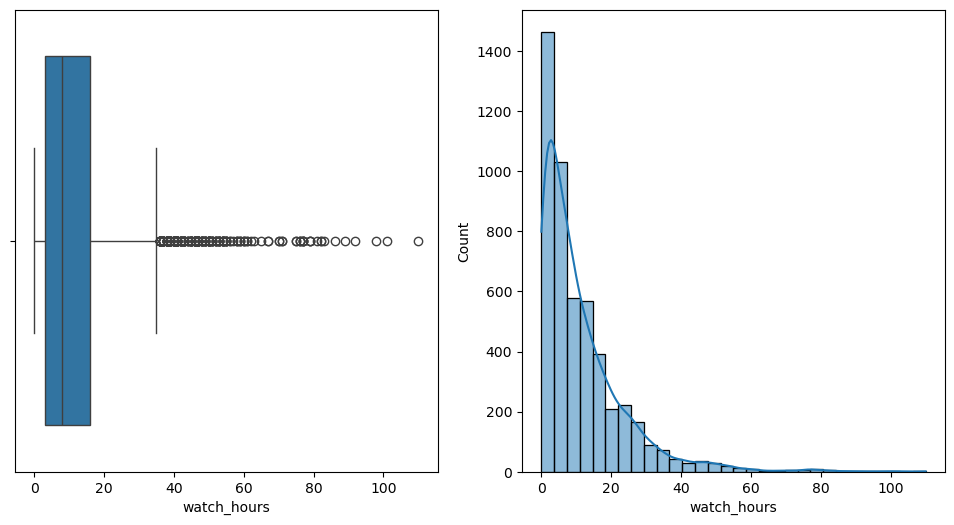

In [14]:
# watch_hours 이상치, 분포 확인
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=onehot_df['watch_hours'])
plt.subplot(1, 2, 2)
sns.histplot(onehot_df['watch_hours'], bins=30, kde=True)
plt.show()

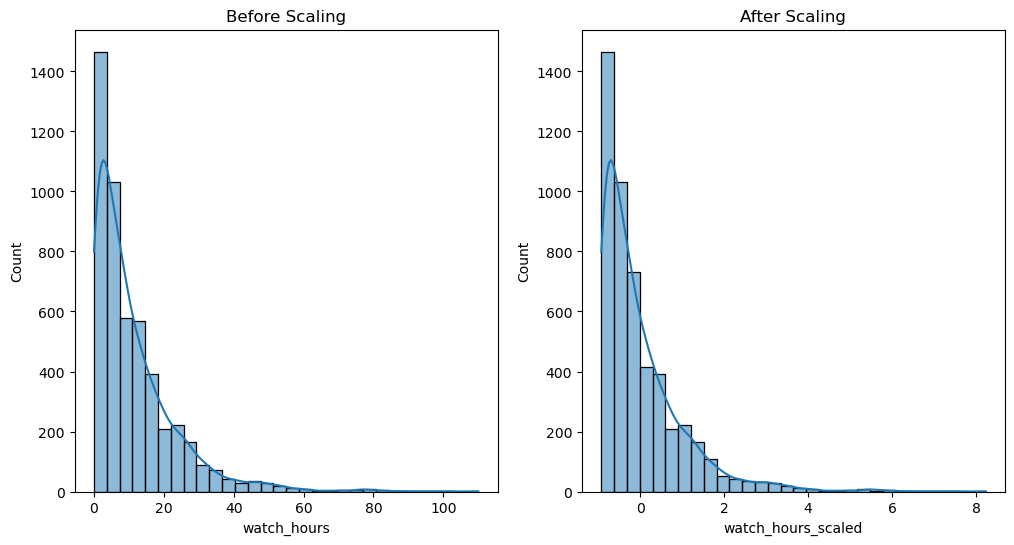

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
onehot_df['watch_hours_scaled'] = scaler.fit_transform(onehot_df[['watch_hours']])

# 스케일링 전후 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(onehot_df['watch_hours'], bins=30, kde=True)
plt.title('Before Scaling')
plt.subplot(1, 2, 2)
sns.histplot(onehot_df['watch_hours_scaled'], bins=30, kde=True)
plt.title('After Scaling')
plt.show()

In [16]:
onehot_df.head()

,age,watch_hours,churned,number_of_profiles,avg_watch_time_per_day,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,...,device_TV,device_Tablet,favorite_genre_Action,favorite_genre_Comedy,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Horror,favorite_genre_Romance,favorite_genre_Sci-Fi,watch_hours_scaled
0,51,14,1,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0.236156
1,47,0,1,5,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,-0.929143
2,27,16,0,2,1,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0.402627
3,53,4,1,2,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,-0.596200
4,56,1,1,2,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,-0.845907


##### Age

In [17]:
# age - one hot by age group (drop False)
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']
onehot_df['age_group'] = pd.cut(onehot_df['age'], bins=age_bins, labels=age_labels, right=False)
onehot_df = pd.get_dummies(onehot_df, columns=['age_group'], drop_first=False).astype(int)
onehot_df.head()

,age,watch_hours,churned,number_of_profiles,avg_watch_time_per_day,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,...,favorite_genre_Romance,favorite_genre_Sci-Fi,watch_hours_scaled,age_group_0-18,age_group_19-25,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+
0,51,14,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,47,0,1,5,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,27,16,0,2,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,53,4,1,2,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,56,1,1,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


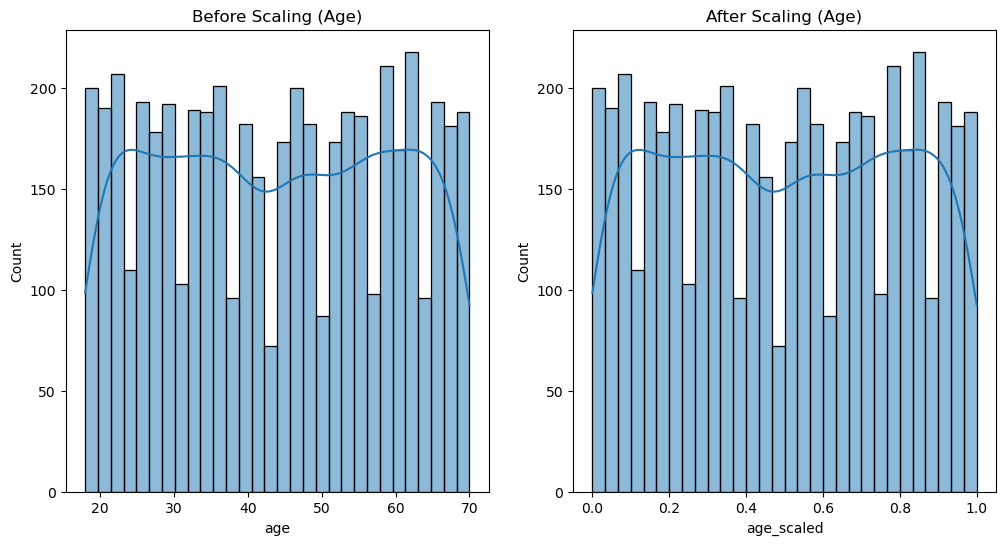


원본 나이와 스케일링된 나이 비교:
   age  age_scaled
0   51    0.634615
1   47    0.557692
2   27    0.173077
3   53    0.673077
4   56    0.730769


In [18]:
# age Scaling by MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# 나이 스케일링
scaler = MinMaxScaler()
onehot_df['age_scaled'] = scaler.fit_transform(onehot_df[['age']])

# 스케일링 전후 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(onehot_df['age'], bins=30, kde=True)
plt.title('Before Scaling (Age)')
plt.subplot(1, 2, 2)
sns.histplot(onehot_df['age_scaled'], bins=30, kde=True)
plt.title('After Scaling (Age)')
plt.show()

# 원본 데이터와 스케일링된 데이터의 처음 몇 행 확인
print("\n원본 나이와 스케일링된 나이 비교:")
print(onehot_df[['age', 'age_scaled']].head())

In [19]:
onehot_df

,age,watch_hours,churned,number_of_profiles,avg_watch_time_per_day,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,...,favorite_genre_Sci-Fi,watch_hours_scaled,age_group_0-18,age_group_19-25,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,age_scaled
0,51,14,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.634615
1,47,0,1,5,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0.557692
2,27,16,0,2,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0.173077
3,53,4,1,2,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0.673077
4,56,1,1,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0.730769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,19,49,0,4,4,1,0,1,0,0,...,0,3,0,1,0,0,0,0,0,0.019231
4996,67,9,0,3,3,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.942308
4997,66,16,1,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0.923077
4998,59,9,0,4,2,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0.788462


In [53]:
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         5000 non-null   int64  
 1   watch_hours                 5000 non-null   int64  
 2   churned                     5000 non-null   int64  
 3   number_of_profiles          5000 non-null   int64  
 4   avg_watch_time_per_day      5000 non-null   int64  
 5   gender_Female               5000 non-null   int64  
 6   gender_Male                 5000 non-null   int64  
 7   gender_Other                5000 non-null   int64  
 8   subscription_type_Basic     5000 non-null   int64  
 9   subscription_type_Premium   5000 non-null   int64  
 10  subscription_type_Standard  5000 non-null   int64  
 11  region_Africa               5000 non-null   int64  
 12  region_Asia                 5000 non-null   int64  
 13  region_Europe               5000 

In [54]:
onehot_df.describe()

,age,watch_hours,churned,number_of_profiles,avg_watch_time_per_day,gender_Female,gender_Male,gender_Other,subscription_type_Basic,subscription_type_Premium,...,favorite_genre_Sci-Fi,watch_hours_scaled,age_group_0-18,age_group_19-25,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,age_scaled
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,43.847400,11.162800,0.503000,3.024400,0.562400,0.342200,0.330800,0.327000,0.332200,0.338600,...,0.144000,0.204000,0.0,0.141400,0.189400,0.180000,0.181200,0.195600,0.11240,0.497065
std,15.501128,12.015289,0.500041,1.415841,2.573991,0.474494,0.470548,0.469164,0.471049,0.473281,...,0.351125,0.653964,0.0,0.348469,0.391865,0.384226,0.385222,0.396702,0.31589,0.298099
min,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,30.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.230769
50%,44.000000,8.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.500000
75%,58.000000,16.000000,1.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.769231
max,70.000000,110.000000,1.000000,5.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,8.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [20]:
# 분류 모델 파이프라인 생성 후 학습 및 평가
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# './data/netflix_customer_churn_preprocessed.csv' 파일 불러와서 train test split
preprocessed_df = pd.read_csv('./data/netflix_customer_churn_preprocessed.csv')

X = preprocessed_df.drop(columns=['churned', 'age', 'watch_hours', 'age_scaled'])
y = preprocessed_df['churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 간단한 파이프라인(KNeighborsClassifier, SVC, LogisticRegression, DecisionTreeClassifier) 생성 및 모델 학습
pipelines = {
    'knn': Pipeline([('knn', KNeighborsClassifier())]),
    'svc': Pipeline([('svc', SVC())]),
    'logreg': Pipeline([('logreg', LogisticRegression(max_iter=1000))])
}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} test accuracy: {score:.4f}, train accuracy: {pipeline.score(X_train, y_train):.4f}")
    print(f"classification report:\n{classification_report(y_test, pipeline.predict(X_test))}\n {classification_report(y_train, pipeline.predict(X_train))}")


    # Correlation 시각화
    y_pred = pipeline.predict(X_test)
    conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './data/netflix_customer_churn_preprocessed.csv'